<a href="https://colab.research.google.com/github/ced-sys/SubTerra/blob/main/SubTerra_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [55]:
try:
  from xgboost import XGBClassifier
  XGBOOST_AVAILABLE=True
except ImportError:
  XGBOOST_AVAILABLE=False
  print("Warning: XGBoost not available. Install with: pip install xgboost")

In [56]:
models={}
X_train=None
X_test=None
y_train=None
y_test=None
feature_names=None
scaler=StandardScaler()

In [57]:
def load_and_preprocess_data(filepath='/content/training_dataset.csv'):
  global feature_names

  try:
    print(f"Loading dataset from: {filepath}")
    df=pd.read_csv(filepath)
    print(f"Dataset shape: {df.shape}")

    #Remove non-feature columns
    drop_cols=[col for col in df.columns
               if any (keyword in col.lower()
               for keyword in ['fid', 'path', 'layer', 'id'])]

    if drop_cols:
      print(f"Dropping columns: {drop_cols}")
      df_cleaned=df.drop(columns=drop_cols)
    else:
      df_cleaned=df.copy()

    #Separate features and labels
    if 'label' not in df_cleaned.columns:
      raise ValueError("No 'label' column found in dataset")

    X=df_cleaned.drop(columns=['label'])
    y=df_cleaned['label']

    #convert to numeric and handle missing values
    X=X.apply(pd.to_numeric, errors='coerce')

    #Handle missing values
    missing_counts=X.isnull().sum()
    if missing_counts.any():
      print(f"Missing values found: {missing_counts[missing_counts>0]}")
      X=X.fillna(X.median())

    feature_names=list(X.columns)
    print(f"Features: {len(feature_names)}")
    print(f"Label distribution: {y.value_counts().to_dict()}")

    return X, y

  except FileNotFoundError:
    raise FileNotFoundError(f"Dataset file not found: {filepath}")
  except Exception as e:
    raise Exception(f"Error loading dataset: {str(e)}")





In [58]:
def split_data(X, y, test_size=0.25, random_state=42):
  global X_train, X_test, y_train, y_test, scaler

  X_train, X_test, y_train, y_test=train_test_split(
      X, y, test_size=test_size, random_state=random_state,
      stratify=y, shuffle=True
  )

  #Scale features for better perfoemance
  X_train_scaled=scaler.fit_transform(X_train)
  X_test_scaled=scaler.transform(X_test)

  print(f"Training set: {X_train.shape[0]} samples")
  print(f"Testing set: {X_test.shape[0]} samples")

  return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

In [59]:
def train_models(X_train, y_train, X_train_scaled, random_state=42):
  global models

  print("\nTraining models...")

  #Decision tree
  models['decision_tree']=DecisionTreeClassifier(
      max_depth=8,
      min_samples_split=10,
      min_samples_leaf=5,
      random_state=random_state
  )

  #Random forest
  models['random_forest']=RandomForestClassifier(
      n_estimators=100,
      max_depth=10,
      min_samples_split=10,
      random_state=random_state,
      n_jobs=-1
  )

  #XGBoost
  if XGBOOST_AVAILABLE:
    models['wgboost']=XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=random_state,
        eval_metric='logloss',
        use_label_encoder=False
    )

  #Train all models
  for name, model in models.items():
    print(f"Training {name}...")
    if name == 'xgbost':
      model.fit(X_train_scaled, y_train)
    else:
      model.fit(X_train, y_train)

  print("All models trained successfully")
  return models

In [60]:
def evaluate_models(X_test, y_test, X_test_scaled):
  print("\n"+"="*60)
  print("MODEL EVALUATION RESULTS")
  print("="*60)

  results={}

  for name, model in models.items():
    print(f"\n--- {name.upper().replace('_', ' ')} ---")

    #Make predictions
    if name == 'xgboost':
      y_pred=model.predict(X_test_scaled)
    else:
      y_pred=model.predict(X_test)

    # Calculate accuracy
    accuracy=accuracy_score(y_test, y_pred)
    results[name]=accuracy

    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # COnfusion matrix
    cm=confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix: \n{cm}")

  #Best model
  best_model=max(results, key=results.get)
  print(f"\nBest performing model: {best_model} (Accuracy: {results[best_model]:.4f})")
  return results

In [61]:
def plot_feature_importance(top_n=15):
  n_models=len(models)
  fig, axes=plt.subplots(1, n_models, figsize=(6*n_models, 8))

  if n_models==1:
    axes=[axes]

  for idx, (name, model) in enumerate(models.items()):
    if hasattr(model, 'feature_importances_'):
      importances=model.feature_importances_
      indices=np.argsort(importances)[::-1][:top_n]

      ax=axes[idx]
      ax.barh(range(len(indices)), importances[indices])
      ax.set_yticks(range(len(indices)))
      ax.set_yticklabels([feature_names[i] for i in indices])
      ax.set_xlabel('Feature Importance')
      ax.set_title(f'{name.replace("_", " ").title()}\nTop {top_n} Features')
      ax.invert_yaxis()

  plt.tight_layout()
  plt.show()

In [62]:
def explain_decision_tree():
  if 'decision_tree' in models:
    print("\n"+"="*60)
    print("DECISION TREE RULES")
    print("="*60)
    tree_rules=export_text(
        models['decision_tree'],
        feature_names=feature_names,
        max_depth=5
    )
    print(tree_rules)
  else:
    print("Decision tree not available for explanation")

In [63]:
def predict_single_sample(features, model_name='decision_tree'):
  if model_name not in models:
    raise ValueError(f"Model {model_name} not availbale")

  model=models[model_name]

  #Convert features to array
  if isinstance(features, dict):
    feature_array=np.array([features.get(name, 0) for name in feature_names])
  else:
    feature_array=np.array(features)

  feature_array=feature_array.reshape(1, -1)

  #Scale if needed
  if model_name=='xgboost':
    feature_array=scaler.transform(feature_array)

  #Make prediction
  prediction=model.predict(feature_array)[0]

  #Get probability if available
  if hasattr(model, 'predict_proba'):
    if model_name=='xgboost':
      probabilities=model.predict_proba(feature_array.reshape(1, -1))[0]
    else:
      probabilities=None

    return {
        'prediction': int(prediction),
        'prediction_label': 'Positive' if prediction==1 else 'Negative',
        'probabilities': probabilities,
        'model_used': model_name
    }



In [64]:
def interactive_classification():
  print("\n"+"="*60)
  print("INTERACTIVE GEOTHERMAL POTENTIAL CLASSIFIER")
  print("="*60)
  print("Enter feature values to classify geothermal potential")
  print("Press Ctrl+C to exit")

  while True:
    try:
      features={}
      print(f"\nEnter values for {len(feature_names)} features:")

      for feature in feature_names:
        while True:
          try:
            value=input(f"{feature}:")
            features[feature]=float(value)
            break
          except ValueError:
            print("Please enter a valid number")

      #Get predictions from all models
      print("\nPrediction Results:")
      print("-"*40)

      for model_name in models.keys():
        result=predict_single_sample(features, model_name)
        print(f"{model_name.replace('_', ' ').title()}: {result['prediction_label']}")

        if result['probabilities'] is not None:
          prob_negative=result['probabilities'][0]
          prob_positive=result['probabilities'][1]
          print(f"Confidence: {max(prob_negative, prob_positive):.3f}")

      print("\nWould you like to classify another sample? (y/n): ", end="")
      if input().lower() !='y':
        break

    except KeyboardInterrupt:
      print("\nExiting interactive mode.")
      break
    except Exception as e:
      print(f"Error: {str(e)}")

In [65]:
def run_full_pipeline(filepath='/content/training_dataset.csv', test_size=0.25, random_state=42):
  print("SubTerra Geothermal Potential Classifier")
  print("="*60)

  try:
    X, y=load_and_preprocess_data(filepath)

    X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled=split_data(
        X, y, test_size, random_state
    )

    trained_models=train_models(X_train, y_train, X_train_scaled, random_state)

    results=evaluate_models(X_test, y_test, X_test_scaled)

    plot_feature_importance()
    explain_decision_tree()

    return trained_models, results

  except Exception as e:
    print(f"Error: {str(e)}")
    print("Please ensure your dataset is properly formatted and accessible")
    return None, None


SubTerra Geothermal Potential Classifier
Loading dataset from: /content/training_dataset.csv
Dataset shape: (86, 41)
Dropping columns: ['fid', 'layer', 'path', 'fid.1', 'layer.1', 'path.1', 'fid.2', 'layer.2', 'path.2', 'fid.3', 'layer.3', 'path.3', 'fid.4', 'layer.4', 'path.4', 'fid.5', 'layer.5', 'path.5', 'fid.6', 'layer.6', 'path.6', 'fid.7', 'layer.7', 'path.7', 'fid.8', 'layer.8', 'path.8', 'fid.9', 'layer.9', 'path.9']
Features: 10
Label distribution: {1: 68, 0: 18}
Training set: 64 samples
Testing set: 22 samples

Training models...
Training decision_tree...
Training random_forest...
Training wgboost...
All models trained successfully

MODEL EVALUATION RESULTS

--- DECISION TREE ---
Accuracy: 0.9545

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.94      1.00      0.97        17

    accuracy                           0.95        22
   macro avg       0.97      0.90      0.

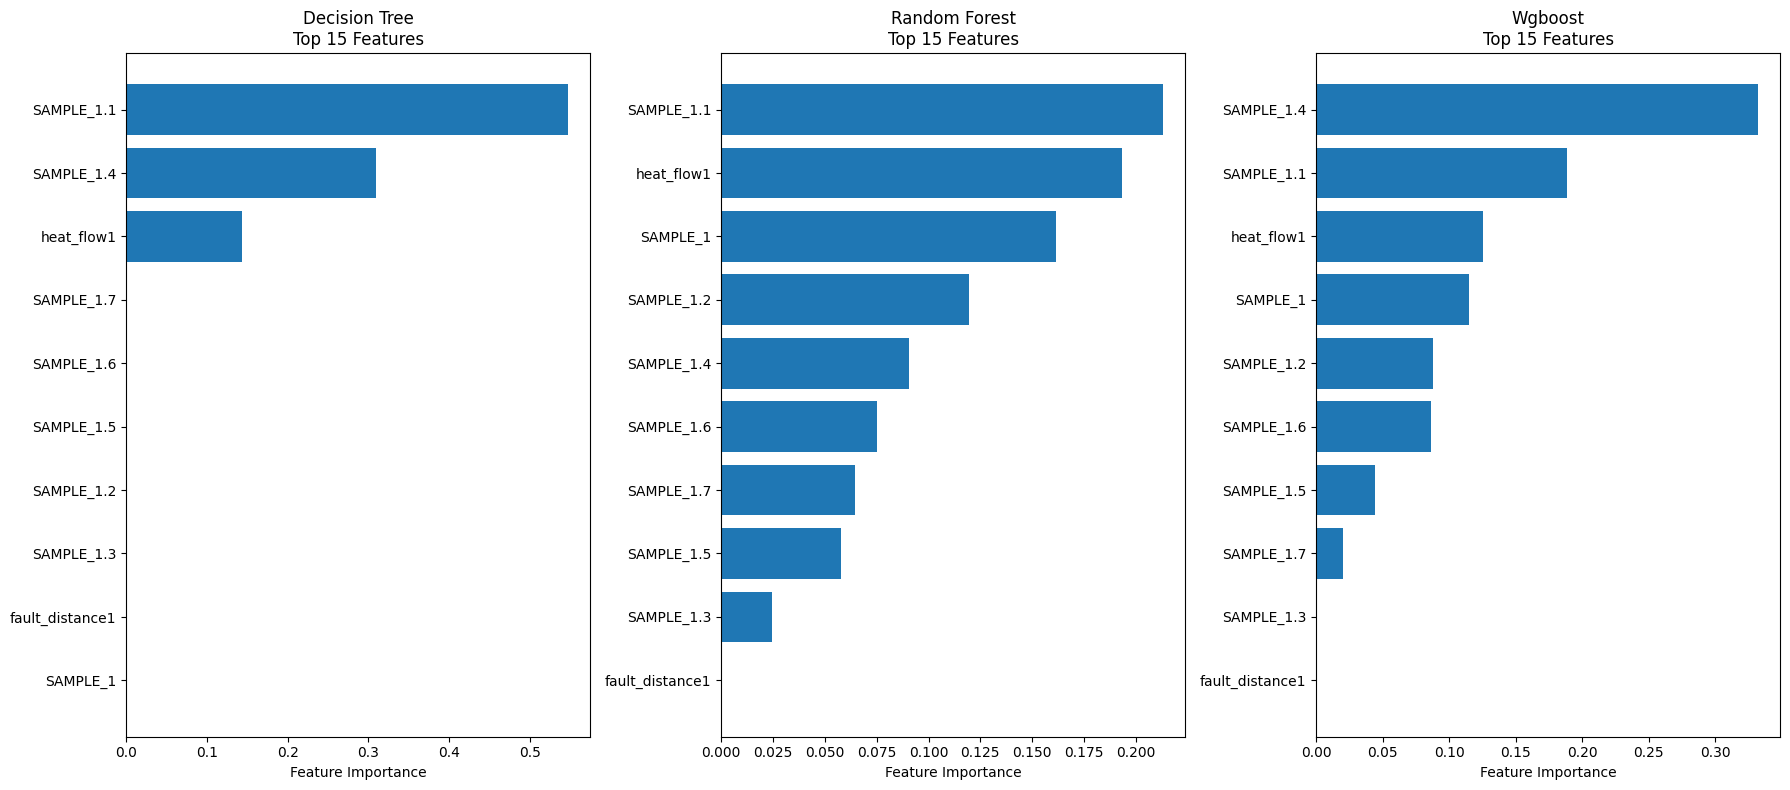


DECISION TREE RULES
|--- SAMPLE_1.1 <= 548.36
|   |--- class: 0
|--- SAMPLE_1.1 >  548.36
|   |--- heat_flow1 <= 106.50
|   |   |--- SAMPLE_1.1 <= 1686.89
|   |   |   |--- SAMPLE_1.4 <= 37.47
|   |   |   |   |--- class: 0
|   |   |   |--- SAMPLE_1.4 >  37.47
|   |   |   |   |--- heat_flow1 <= 88.78
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- heat_flow1 >  88.78
|   |   |   |   |   |--- class: 1
|   |   |--- SAMPLE_1.1 >  1686.89
|   |   |   |--- class: 1
|   |--- heat_flow1 >  106.50
|   |   |--- class: 0


INTERACTIVE GEOTHERMAL POTENTIAL CLASSIFIER
Enter feature values to classify geothermal potential
Press Ctrl+C to exit

Enter values for 10 features:


In [ ]:
if __name__=="__main__":
  trained_models, evaluation_resuts=run_full_pipeline()

  if trained_models:
    interactive_classification()